In [4]:
# for pep-8
!pip install nb_black
!pip install pycodestyle_magic
!pip install pycodestyle
!pip install flake8

<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black
%load_ext pycodestyle_magic

<IPython.core.display.Javascript object>

In [9]:
!pip install gdown

<IPython.core.display.Javascript object>

In [18]:
!pip install pandas numpy seaborn sklearn

<IPython.core.display.Javascript object>

In [6]:
!pip install tensorflow

<IPython.core.display.Javascript object>

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 8.3.0

numpy       : 1.22.3
pandas      : 1.4.3
torch       : 1.11.0+cu113
transformers: 4.21.0



<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import json
import os
import zipfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F00FF",
]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

2022-10-31 12:29:32.599811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 12:29:32.852922: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 12:29:33.493111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-10-31 12:29:33.493381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

<IPython.core.display.Javascript object>

# Download Universal Text Encoder


In [4]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2022-10-31 12:35:01.006653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 12:35:01.088519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 12:35:01.088728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 12:35:01.089157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<IPython.core.display.Javascript object>

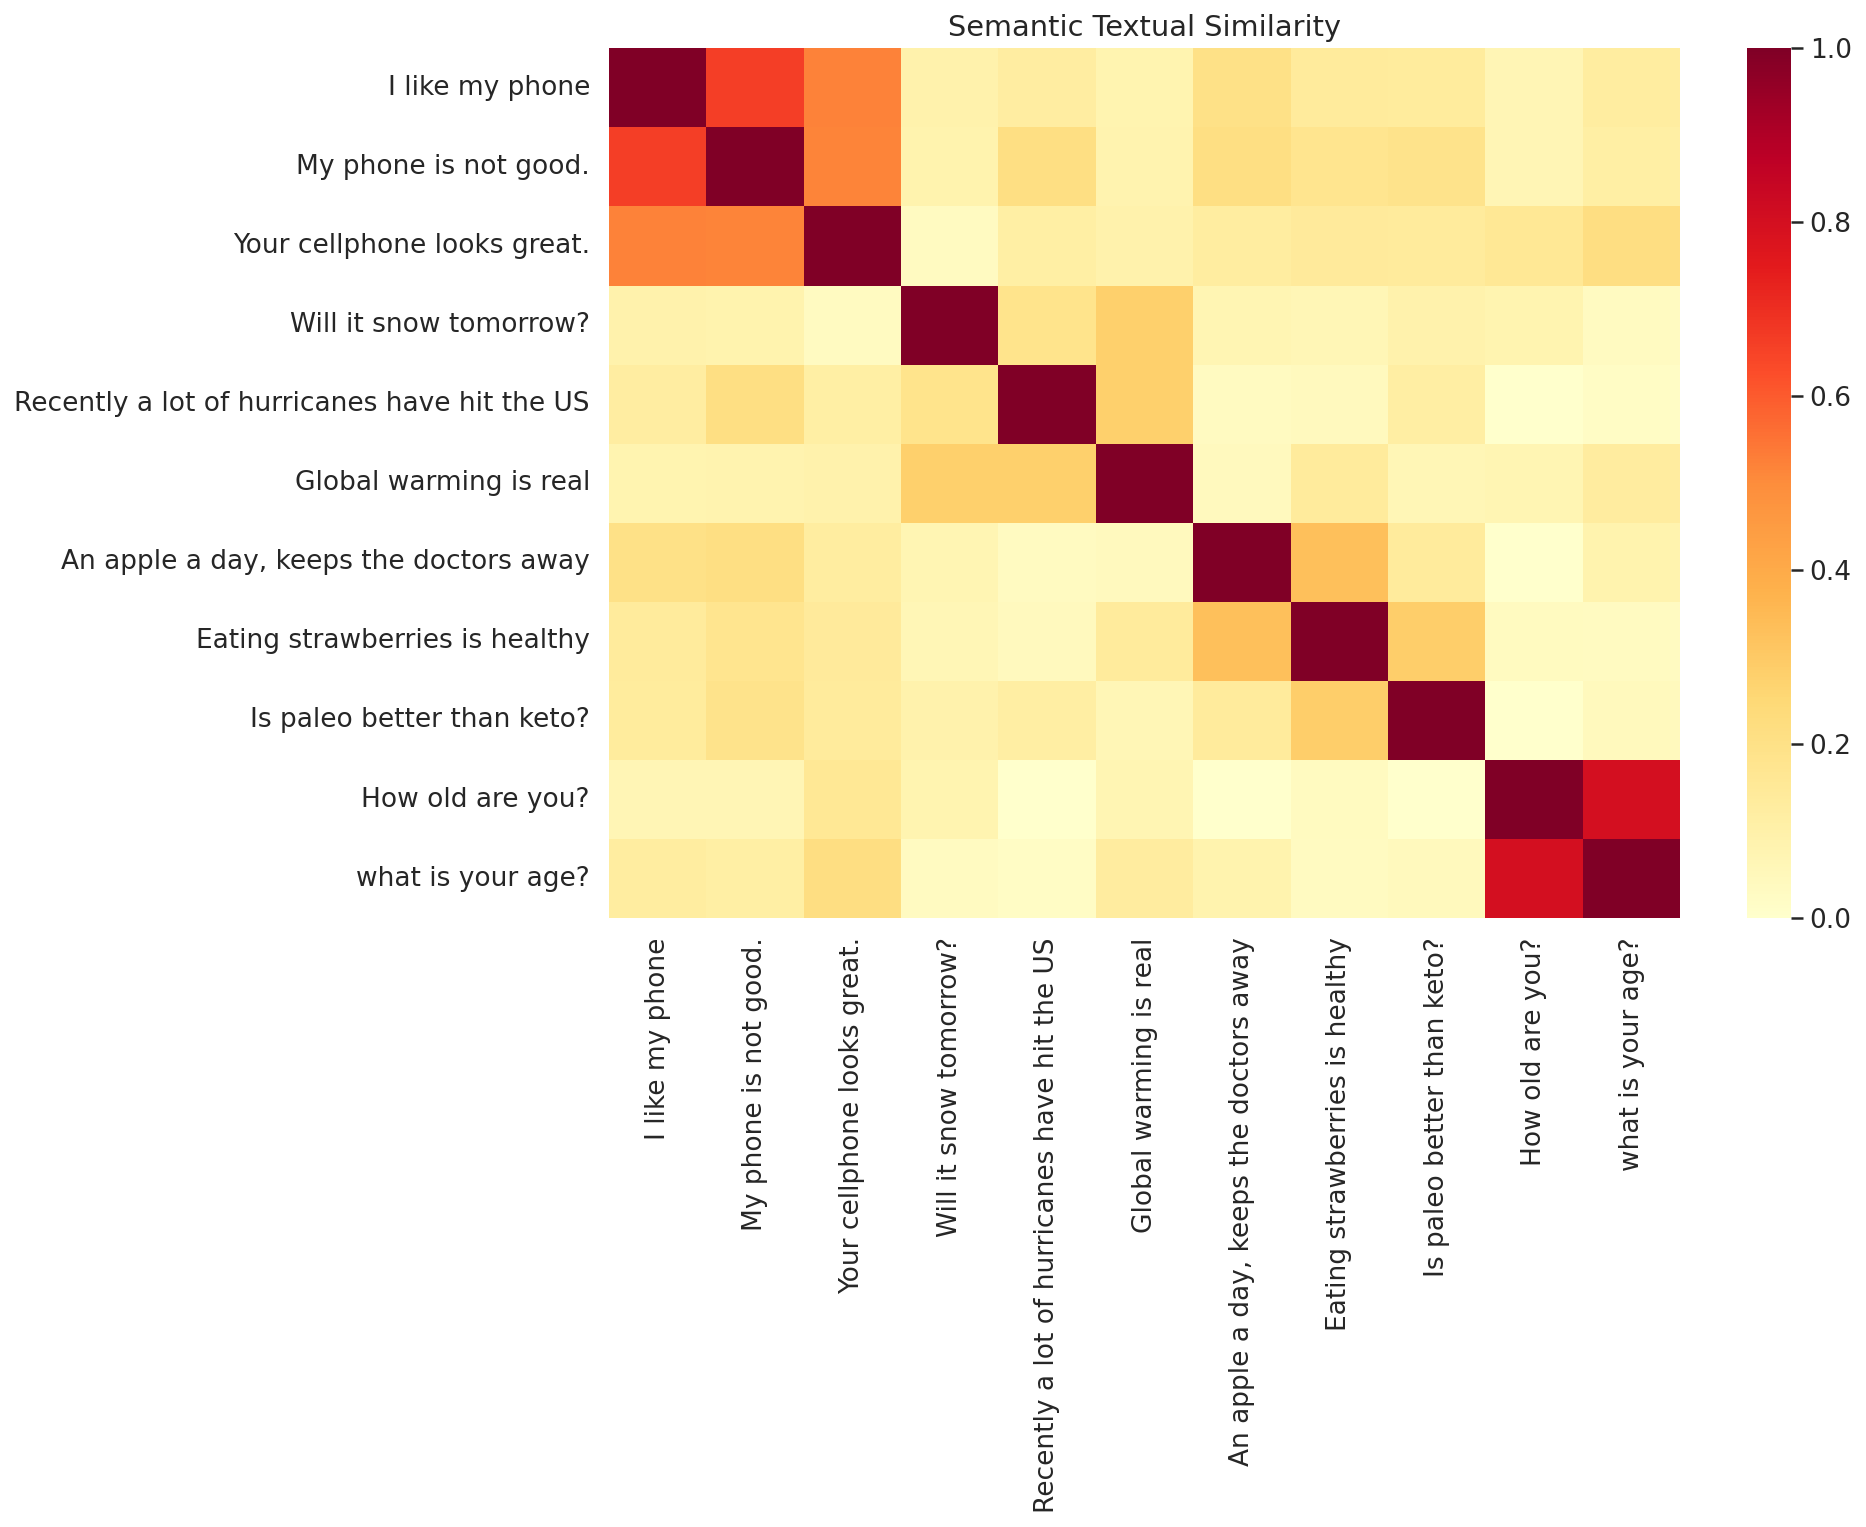

<IPython.core.display.Javascript object>

In [6]:
def embed(input):
    return use(input)


def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)


messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",
    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",
    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",
    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

# Data Exploration
I'm using the public dataset Financial PhraseBank (https://arxiv.org/abs/1307.5336).
It consists of 4845 english sentences selected randomly from financial news, labeled according to how the information contained might affect the mentioned company stock price: positive, negative or neutral.


## Download the dataset

In [7]:
df = pd.read_csv("data_light/financial_news_dataset/financial_news_data.csv")

<IPython.core.display.Javascript object>

In [8]:
df.columns = ["sentiment", "statement", "0", "1"]

<IPython.core.display.Javascript object>

In [9]:
df = df.rename(
    columns={
        "neutral": "sentiment",
        "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .": "statement",
    }
)

<IPython.core.display.Javascript object>

In [10]:
df.columns

Index(['sentiment', 'statement', '0', '1'], dtype='object')

<IPython.core.display.Javascript object>

In [11]:
df = df[["sentiment", "statement"]]

<IPython.core.display.Javascript object>

In [12]:
df.head()

,sentiment,statement
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


<IPython.core.display.Javascript object>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4845 non-null   object
 1   statement  4845 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


<IPython.core.display.Javascript object>

We have about 4845 examples. Let's check for missing values:

Great, no missing values in the score and review texts!

Text(0.5, 0, 'sentiment')

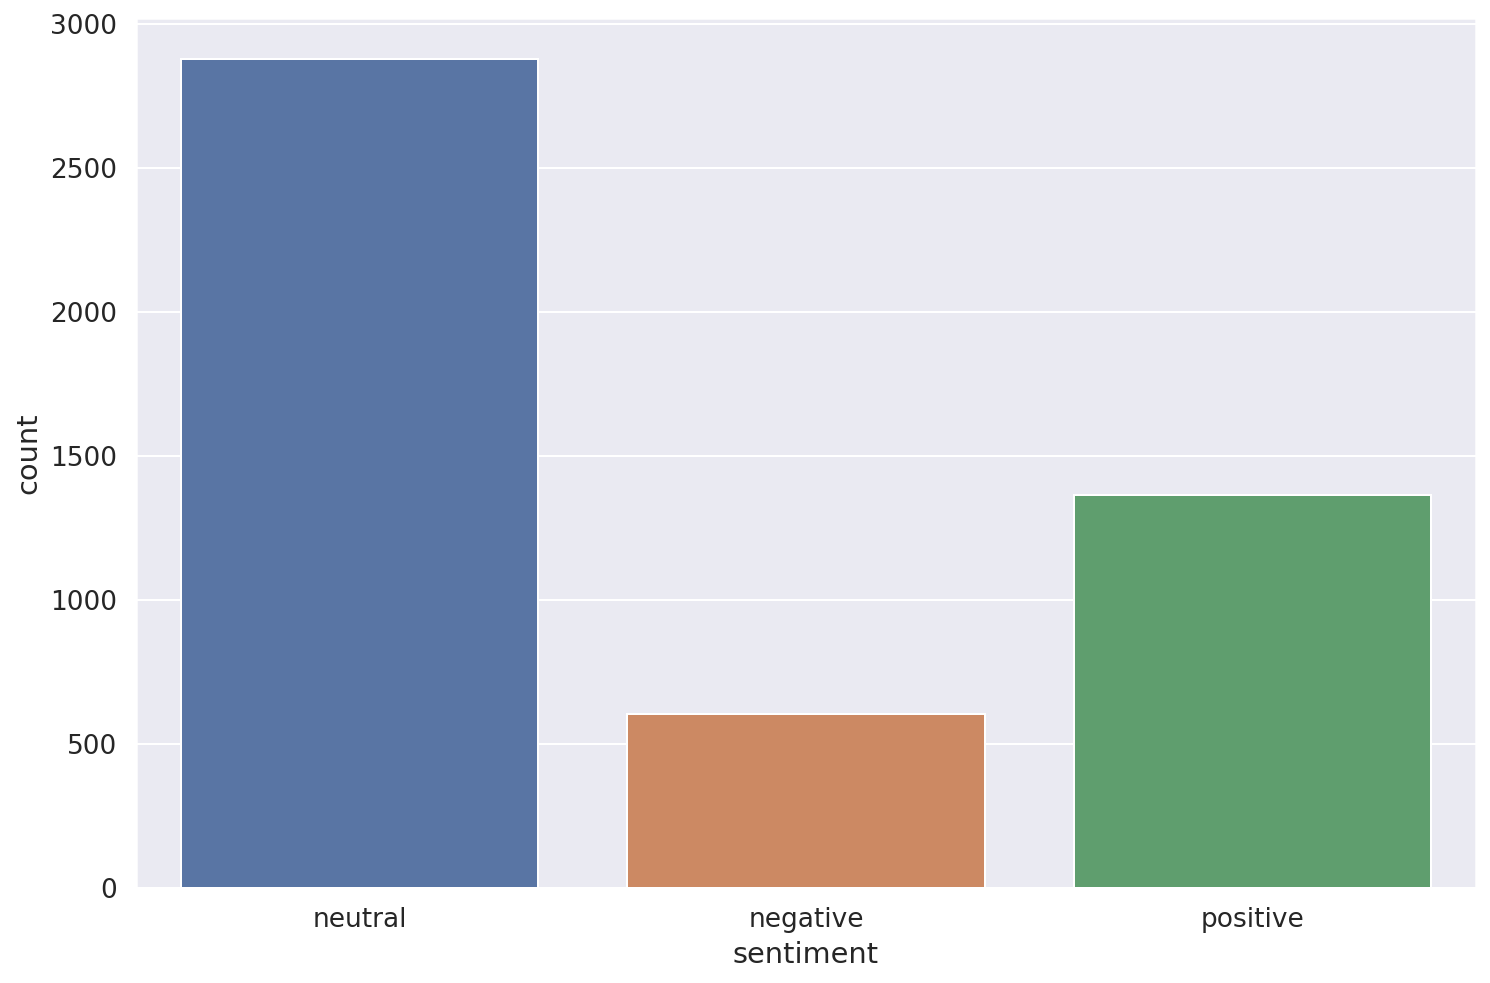

<IPython.core.display.Javascript object>

In [14]:
sns.countplot(x="sentiment", data=df)
plt.xlabel("sentiment")

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

<IPython.core.display.Javascript object>

In [16]:
one_hot_enc = enc.fit_transform(df.sentiment.to_numpy().reshape(-1, 1))

<IPython.core.display.Javascript object>

In [17]:
one_hot_enc[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

<IPython.core.display.Javascript object>

In [18]:
enc.categories_

[array(['negative', 'neutral', 'positive'], dtype=object)]

<IPython.core.display.Javascript object>

In [19]:
enc.inverse_transform(one_hot_enc[:10])

array([['neutral'],
       ['negative'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive'],
       ['positive']], dtype=object)

<IPython.core.display.Javascript object>

In [20]:
positive = [0, 0, 1]
negative = [1, 0, 0]
neutral = [0, 1, 0]

<IPython.core.display.Javascript object>

In [21]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df.statement, one_hot_enc, test_size=0.2, random_state=RANDOM_SEED
)

<IPython.core.display.Javascript object>

In [22]:
X_train = []
for r in tqdm(train_reviews):
    emb = use([r])
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████████████████████████████████| 3876/3876 [00:11<00:00, 350.34it/s]


<IPython.core.display.Javascript object>

In [23]:
X_test = []
for r in tqdm(test_reviews):
    emb = use([r])
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|████████████████████████████████████████| 969/969 [00:02<00:00, 353.58it/s]


<IPython.core.display.Javascript object>

In [24]:
X_train.shape, X_test.shape

((3876, 512), (969, 512))

<IPython.core.display.Javascript object>

In [25]:
model = keras.Sequential()

model.add(
    keras.layers.Dense(units=256, input_shape=(X_train.shape[1],), activation="relu")
)
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(3, activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 164,611
Trainable params: 164,611
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

# Don't want to wait? Uncomment the next cell and download my pre-trained model on loading model section:

In [27]:
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)

Epoch 1/15
109/109 [==============================] - 1s 3ms/step - loss: 1.0417 - accuracy: 0.5387 - val_loss: 0.9802 - val_accuracy: 0.5799
Epoch 2/15
109/109 [==============================] - 0s 1ms/step - loss: 0.9283 - accuracy: 0.5981 - val_loss: 0.8989 - val_accuracy: 0.5799
Epoch 3/15
109/109 [==============================] - 0s 1ms/step - loss: 0.8641 - accuracy: 0.6038 - val_loss: 0.8458 - val_accuracy: 0.5954
Epoch 4/15
109/109 [==============================] - 0s 2ms/step - loss: 0.8123 - accuracy: 0.6247 - val_loss: 0.7975 - val_accuracy: 0.6263
Epoch 5/15
109/109 [==============================] - 0s 1ms/step - loss: 0.7689 - accuracy: 0.6594 - val_loss: 0.7538 - val_accuracy: 0.6727
Epoch 6/15
109/109 [==============================] - 0s 1ms/step - loss: 0.7281 - accuracy: 0.6806 - val_loss: 0.7186 - val_accuracy: 0.6727
Epoch 7/15
109/109 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.6933
Epoch 

<IPython.core.display.Javascript object>

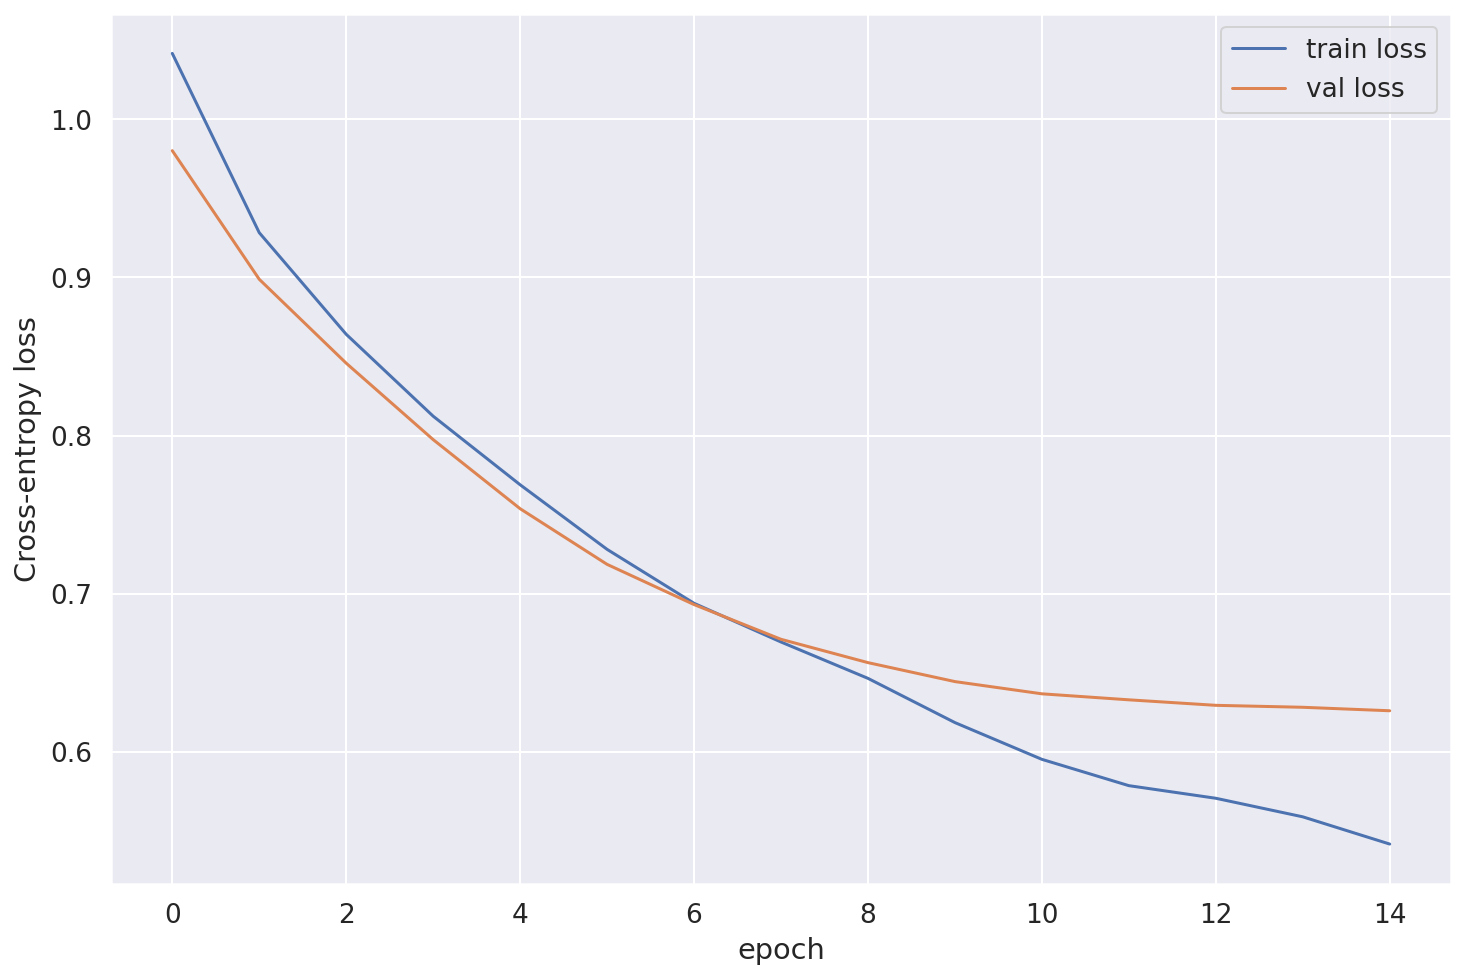

<IPython.core.display.Javascript object>

In [28]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()

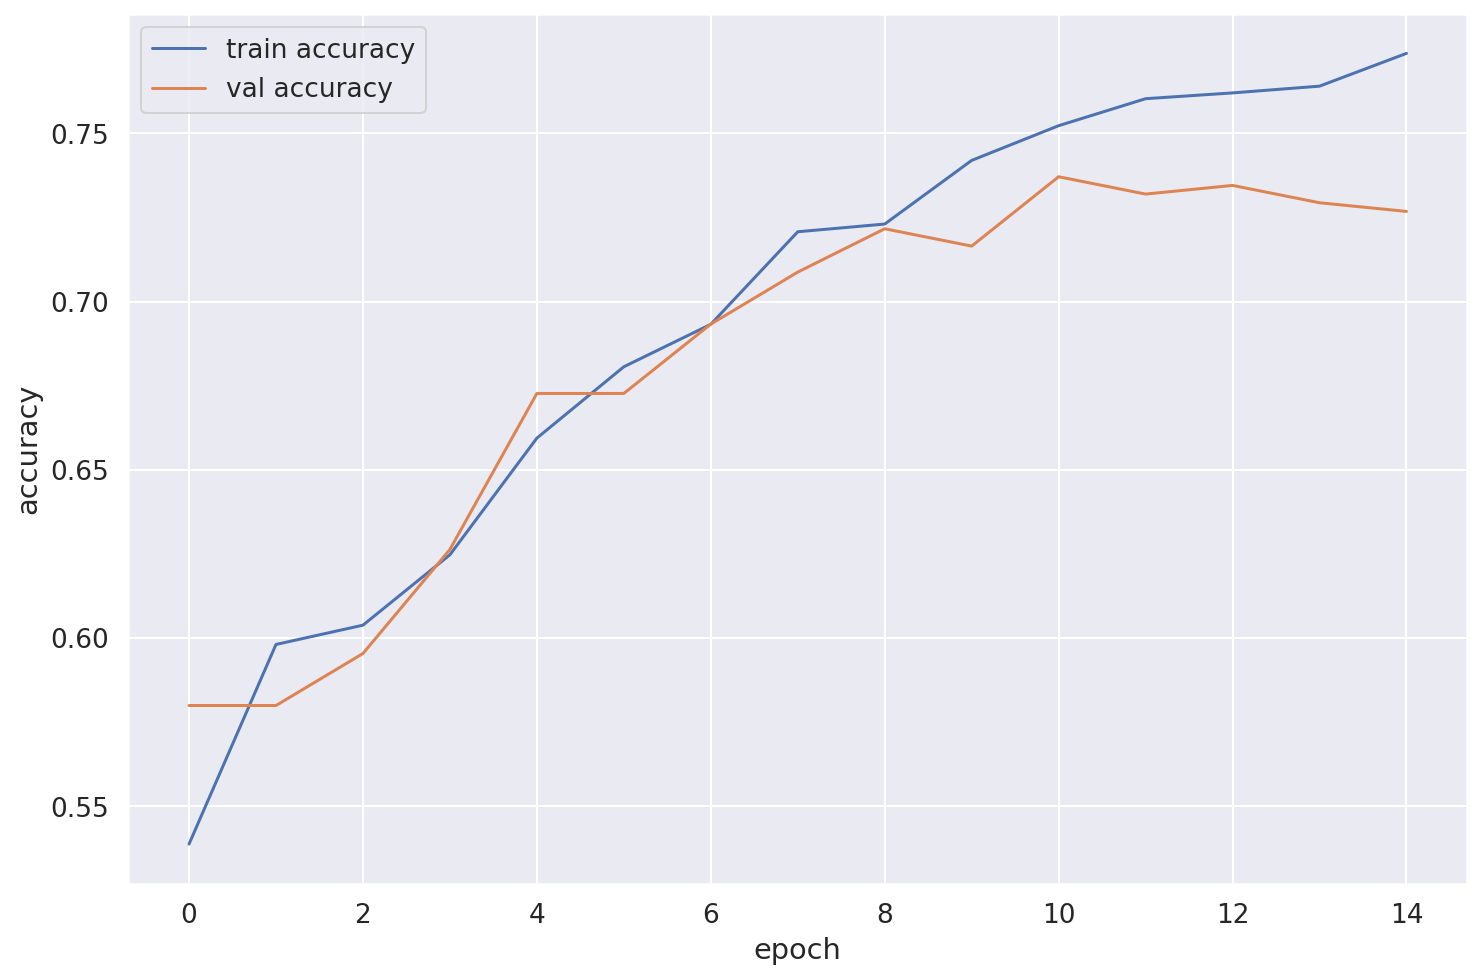

<IPython.core.display.Javascript object>

In [29]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

In [30]:
model.evaluate(X_test, y_test)[1]

31/31 [==============================] - 0s 958us/step - loss: 0.6484 - accuracy: 0.7079


0.7079463601112366

<IPython.core.display.Javascript object>

In [26]:
path = "data/saved_models_use_onnx"
if os.path.exists(path):
    pass
else:
    isExist = os.path.exists(path)
    if not isExist:

        # Create a new directory because it does not exist
        os.makedirs(path)
        print("The new directory is created!")

The new directory is created!


<IPython.core.display.Javascript object>

In [31]:
model.save("data/saved_models_use_onnx")
print("Saved model to disk")

INFO:tensorflow:Assets written to: saved_models_use_onnx/assets
Saved model to disk


<IPython.core.display.Javascript object>

# Load pre-trained model:

In [26]:
from tensorflow.keras.models import load_model

<IPython.core.display.Javascript object>

In [27]:
path = "data"
file_name = "data/saved_models_use_onnx"
if os.path.exists(file_name):
    pass
else:
    isExist = os.path.exists(path)
    if not isExist:

        # Create a new directory because it does not exist
        os.makedirs(path)
        print("The new directory is created!")
    !gdown  -O 'data/saved_models_use_onnx.zip' 1zbJ6Ndo1wYA2-SfE2dTg5s9E_KN4Civh
    with zipfile.ZipFile("data/saved_models_use_onnx.zip", "r") as zip_ref:
        zip_ref.extractall("data")

<IPython.core.display.Javascript object>

In [28]:
# load model
model = load_model("data/saved_models_use_onnx")
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 164,611
Trainable params: 164,611
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [29]:
y_pred = model.predict(X_test)

31/31 [==============================] - 0s 709us/step


<IPython.core.display.Javascript object>

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

<IPython.core.display.Javascript object>

In [31]:
class_names = ["negative", "neutral", "positive"]

<IPython.core.display.Javascript object>

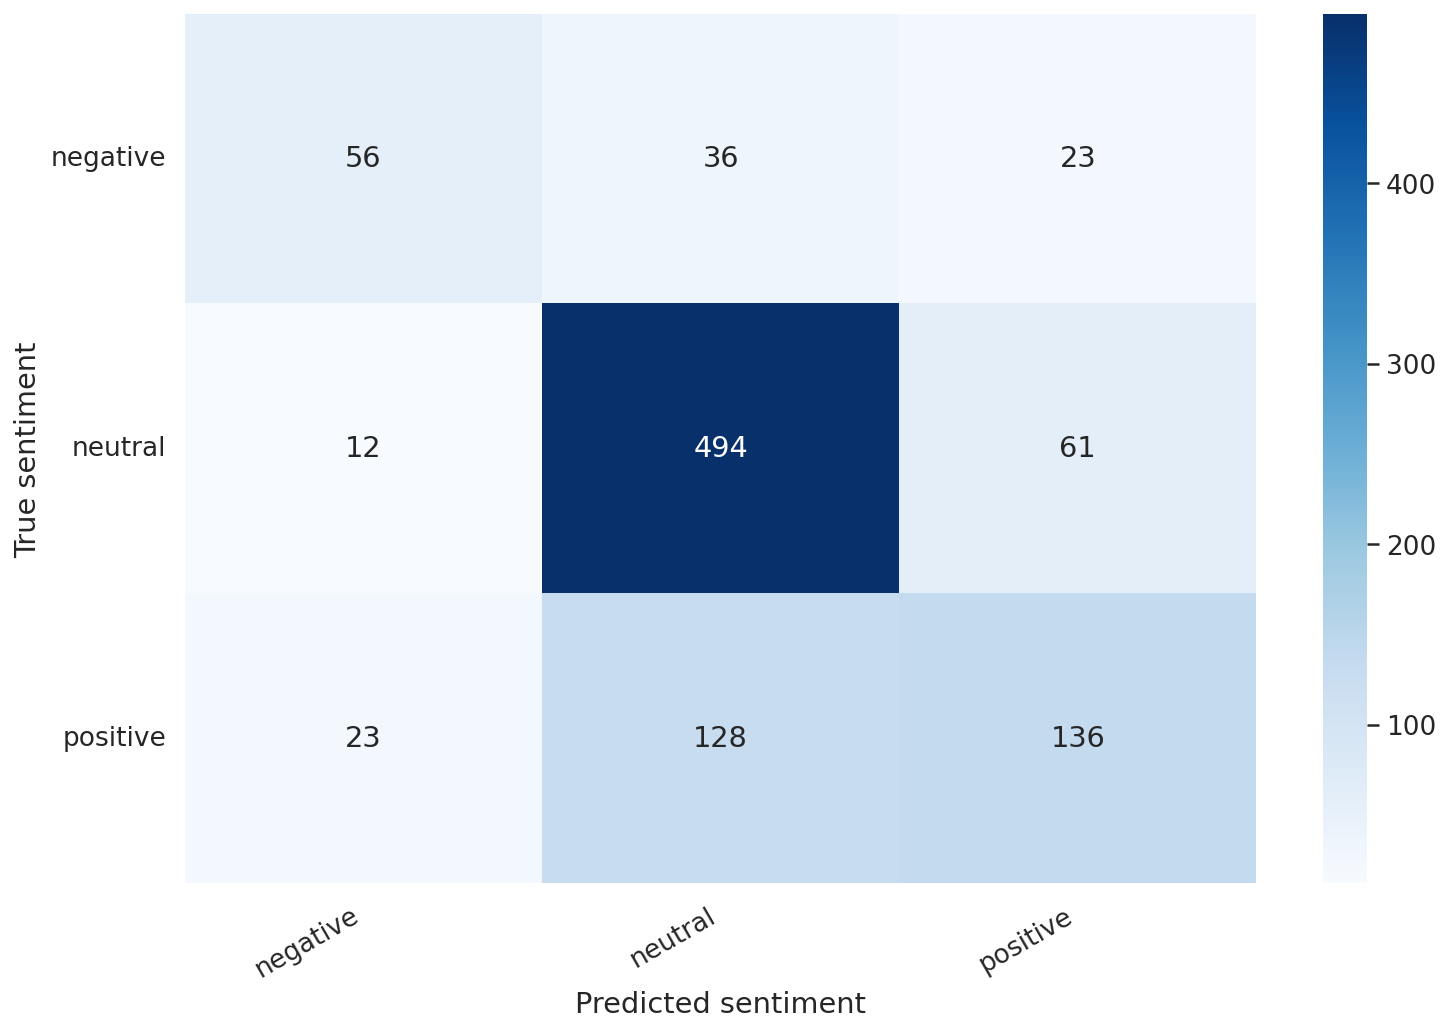

<IPython.core.display.Javascript object>

In [32]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel("True sentiment")
    plt.xlabel("Predicted sentiment")


cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Converting model to ONNX

In [36]:
!python -m tf2onnx.convert --saved-model data/saved_models_use_onnx  --output data/saved_models_use_onnx/sent_anal.onnx --opset 12 --extra_opset ai.onnx.contrib:1 --tag serve

2022-10-25 08:40:24.574866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 08:40:24.677842: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-25 08:40:24.999071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-10-25 08:40:24.999118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

<IPython.core.display.Javascript object>

# Load ONNX model

In [33]:
import onnxruntime as ort
from onnxruntime_extensions import get_library_path

so = ort.SessionOptions()
so.register_custom_ops_library(get_library_path())

sess = ort.InferenceSession("data/saved_models_use_onnx/sent_anal.onnx", so)

<IPython.core.display.Javascript object>

In [34]:
print("Inputs:", [inp.name for inp in sess.get_inputs()])
print("Outputs:", [out.name for out in sess.get_outputs()])

Inputs: ['dense_input']
Outputs: ['dense_2']


<IPython.core.display.Javascript object>

# Testing

In [35]:
list_test = df["statement"].tolist()

<IPython.core.display.Javascript object>

In [36]:
%%time
result_onnx = []
for r in list_test:
    emb = use([r])
    results_ort = sess.run(["dense_2"], {"dense_input": emb.numpy()})
    result_onnx.append(results_ort)

CPU times: user 54.6 s, sys: 11.5 s, total: 1min 6s
Wall time: 12.1 s


<IPython.core.display.Javascript object>